# Libraries and imports


In [ ]:
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import cv2
from random import sample, shuffle
import os

from torch.utils.data import Dataset

import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from skimage.metrics import structural_similarity as calc_ssim
from skimage.metrics import peak_signal_noise_ratio as calc_psnr
import torchvision.transforms as transforms
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/Shareddrives/hobbit132480/Images.zip -d /content

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/Images/5499.png  
  inflating: /content/Images/55.png  
  inflating: /content/Images/550.png  
  inflating: /content/Images/5500.png  
  inflating: /content/Images/5501.png  
  inflating: /content/Images/5502.png  
  inflating: /content/Images/5503.png  
  inflating: /content/Images/5504.png  
  inflating: /content/Images/5505.png  
  inflating: /content/Images/5506.png  
  inflating: /content/Images/5507.png  
  inflating: /content/Images/5508.png  
  inflating: /content/Images/5509.png  
  inflating: /content/Images/551.png  
  inflating: /content/Images/5510.png  
  inflating: /content/Images/5511.png  
  inflating: /content/Images/5512.png  
  inflating: /content/Images/5513.png  
  inflating: /content/Images/5514.png  
  inflating: /content/Images/5515.png  
  inflating: /content/Images/5516.png  
  inflating: /content/Images/5517.png  
  inflating: /content/Images/5518.png  
  inflating: /co

# Training Process

In [ ]:
def gauss_noise(image):
    row,col= image.shape
    mean = 0.002
    var = 0.001
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    noisy = np.clip(noisy, 0.0, 1.0)
    return noisy.astype(np.float32)

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, dirs):
        super(TrainDataset, self).__init__()
        self.lr = []
        self.hr = []
        self.patch_size = 33
        self.stride = 14
        self.scale = 4
        self.size = 512
        self.dirs = dirs
        '''for dir in dirs:
          hr = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
          hr = hr.astype(np.float32) / 255.
          #lr = gauss_noise(np.array(hr))
          lr = hr
          lr = cv2.resize(lr, (self.size // self.scale, self.size // self.scale), interpolation=cv2.INTER_CUBIC)
          lr = cv2.resize(lr, (self.size, self.size), interpolation=cv2.INTER_CUBIC)
          for i in range(0, lr.shape[0] - self.patch_size + 1, self.stride):
                for j in range(0, lr.shape[1] - self.patch_size + 1, self.stride):
                    self.lr.append(lr[i:i + self.patch_size, j:j + self.patch_size])
                    self.hr.append(hr[i:i + self.patch_size, j:j + self.patch_size])'''

    @staticmethod
    def random_crop(lr, hr, size, scale):
        lr_left = random.randint(0, lr.shape[1] - size)
        lr_right = lr_left + size
        lr_top = random.randint(0, lr.shape[0] - size)
        lr_bottom = lr_top + size
        lr = lr[lr_top:lr_bottom, lr_left:lr_right]
        hr = hr[lr_top:lr_bottom, lr_left:lr_right]
        return lr, hr


    @staticmethod
    def random_horizontal_flip(lr, hr):
        if random.random() < 0.5:
            lr = lr[:, ::-1].copy()
            hr = hr[:, ::-1].copy()
        return lr, hr

    @staticmethod
    def random_vertical_flip(lr, hr):
        if random.random() < 0.5:
            lr = lr[::-1, :].copy()
            hr = hr[::-1, :].copy()
        return lr, hr

    def __getitem__(self, idx):
        dir = self.dirs[idx]
        hr = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
        hr = hr.astype(np.float32) / 255.
        lr = gauss_noise(np.array(hr))
        #lr = hr
        lr = cv2.resize(lr, (self.size // self.scale, self.size // self.scale), interpolation=cv2.INTER_CUBIC)
        lr = cv2.resize(lr, (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        lr, hr = self.random_crop(lr, hr, self.patch_size, self.scale)
        lr, hr = self.random_horizontal_flip(lr, hr)
        lr, hr = self.random_vertical_flip(lr, hr)
        lr = np.expand_dims(lr, 0).astype(np.float32)
        hr = np.expand_dims(hr, 0).astype(np.float32)
        return lr, hr

    def __len__(self):
        return len(self.dirs)

class EvalDataset(Dataset):
    def __init__(self, dirs):
        super(EvalDataset, self).__init__()
        self.dirs = dirs
        self.scale = 4
        self.size = 512

    def __getitem__(self, idx):
        dir = self.dirs[idx]
        hr = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
        hr = hr.astype(np.float32) / 255.
        lr1 = gauss_noise(np.array(hr))
        #lr1 = hr
        lr1 = cv2.resize(lr1, (self.size // self.scale, self.size // self.scale), interpolation=cv2.INTER_CUBIC)
        lr2 = cv2.resize(lr1, (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        return np.expand_dims(lr1, 0), np.expand_dims(lr2, 0), np.expand_dims(hr, 0)

    def __len__(self):
        return len(self.dirs)

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
data_file = 'Images'
outputs_dir = 'SRCNNOutput'
os.makedirs(outputs_dir, exist_ok=True)
scale = 4
lr = 1e-3
batch_size = 32
num_epochs = 10
num_workers = 0
seed = 123

images = [join(data_file, dir) for dir in listdir(data_file)]
images.sort()

cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(seed)

model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam([
    {'params': model.conv1.parameters()},
    {'params': model.conv2.parameters()},
    {'params': model.conv3.parameters(), 'lr': lr * 0.1}
], lr=lr)

train_dataset = TrainDataset(images[:10000])
train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers,
                                pin_memory=True,
                                drop_last=True)
eval_dataset = EvalDataset(images[-3050:-3040])
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)

eval_psnr_byepoch = []
eval_ssim_byepoch = []
loss_perbatch = []

for epoch in range(num_epochs):
    model.train()
    with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
        t.set_description('epoch: {}/{}'.format(epoch + 1, num_epochs))

        for i, data in enumerate(train_dataloader):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)

            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_perbatch.append(loss.item())
            t.set_postfix(loss='{:.6f}'.format(loss.item()))
            t.update(len(inputs))

            if i % 100 == 0:
                model.eval()
                epoch_psnr = 0
                epoch_ssim = 0

                for data in eval_dataloader:
                    linputs, inputs, labels = data

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    with torch.no_grad():
                        preds = model(inputs)

                    preds = preds.cpu().numpy().squeeze(0).squeeze(0)
                    labels = labels.cpu().numpy().squeeze(0).squeeze(0)
                    epoch_psnr += calc_psnr(preds, labels, data_range=1)
                    epoch_ssim += calc_ssim(preds, labels, data_range=1)

                l = len(eval_dataset)
                epoch_psnr /= l
                epoch_ssim /= l
                eval_psnr_byepoch.append(epoch_psnr)
                eval_ssim_byepoch.append(epoch_ssim)

    torch.save(model.state_dict(), os.path.join(outputs_dir, 'epoch_{}.pth'.format(epoch + 1)))
    print('eval psnr: {:.2f}'.format(epoch_psnr))
    print('eval ssim: {:.2f}'.format(epoch_ssim))

epoch: 1/10: 100%|██████████| 9984/9984 [02:34<00:00, 64.64it/s, loss=0.000979]


eval psnr: 32.23
eval ssim: 0.85


epoch: 2/10: 100%|██████████| 9984/9984 [02:39<00:00, 62.65it/s, loss=0.000660]


eval psnr: 32.64
eval ssim: 0.86


epoch: 3/10: 100%|██████████| 9984/9984 [02:33<00:00, 64.87it/s, loss=0.000746]


eval psnr: 32.82
eval ssim: 0.85


epoch: 4/10: 100%|██████████| 9984/9984 [02:32<00:00, 65.66it/s, loss=0.001254]


eval psnr: 32.82
eval ssim: 0.85


epoch: 5/10: 100%|██████████| 9984/9984 [02:30<00:00, 66.45it/s, loss=0.000475]


eval psnr: 32.99
eval ssim: 0.86


epoch: 6/10: 100%|██████████| 9984/9984 [02:37<00:00, 63.29it/s, loss=0.000896]


eval psnr: 33.02
eval ssim: 0.85


epoch: 7/10: 100%|██████████| 9984/9984 [02:29<00:00, 66.89it/s, loss=0.000471]


eval psnr: 33.13
eval ssim: 0.87


epoch: 8/10: 100%|██████████| 9984/9984 [02:34<00:00, 64.63it/s, loss=0.000721]


eval psnr: 33.03
eval ssim: 0.85


epoch: 9/10: 100%|██████████| 9984/9984 [02:30<00:00, 66.13it/s, loss=0.000582]


eval psnr: 32.87
eval ssim: 0.86


epoch: 10/10: 100%|██████████| 9984/9984 [02:39<00:00, 62.74it/s, loss=0.000395]

eval psnr: 33.11
eval ssim: 0.86


# Results


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SRCNN().to(device)
s_epoch = 9
if s_epoch != 0:
    model.load_state_dict(torch.load(f"epoch_{s_epoch}.pth"))

In [ ]:
images = [join('/content/Images', dir) for dir in listdir('/content/Images')]
images.sort()
val_dataset = EvalDataset(images[-3000:])
eval_dataloader = DataLoader(dataset=val_dataset, batch_size=1)

model.eval()
psnr = 0
ssim = 0

for i, data in enumerate(eval_dataloader):
    linputs, inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        preds = model(inputs)

    preds = preds.cpu().numpy().squeeze(0).squeeze(0)
    labels = labels.cpu().numpy().squeeze(0).squeeze(0)
    psnr += calc_psnr(preds, labels, data_range=1)
    ssim += calc_ssim(preds, labels, data_range=1)


l = len(val_dataset)
psnr /= l
ssim /= l
linputs = linputs.cpu().numpy().squeeze(0).squeeze(0)

32.568850894794366
0.8538742700905183


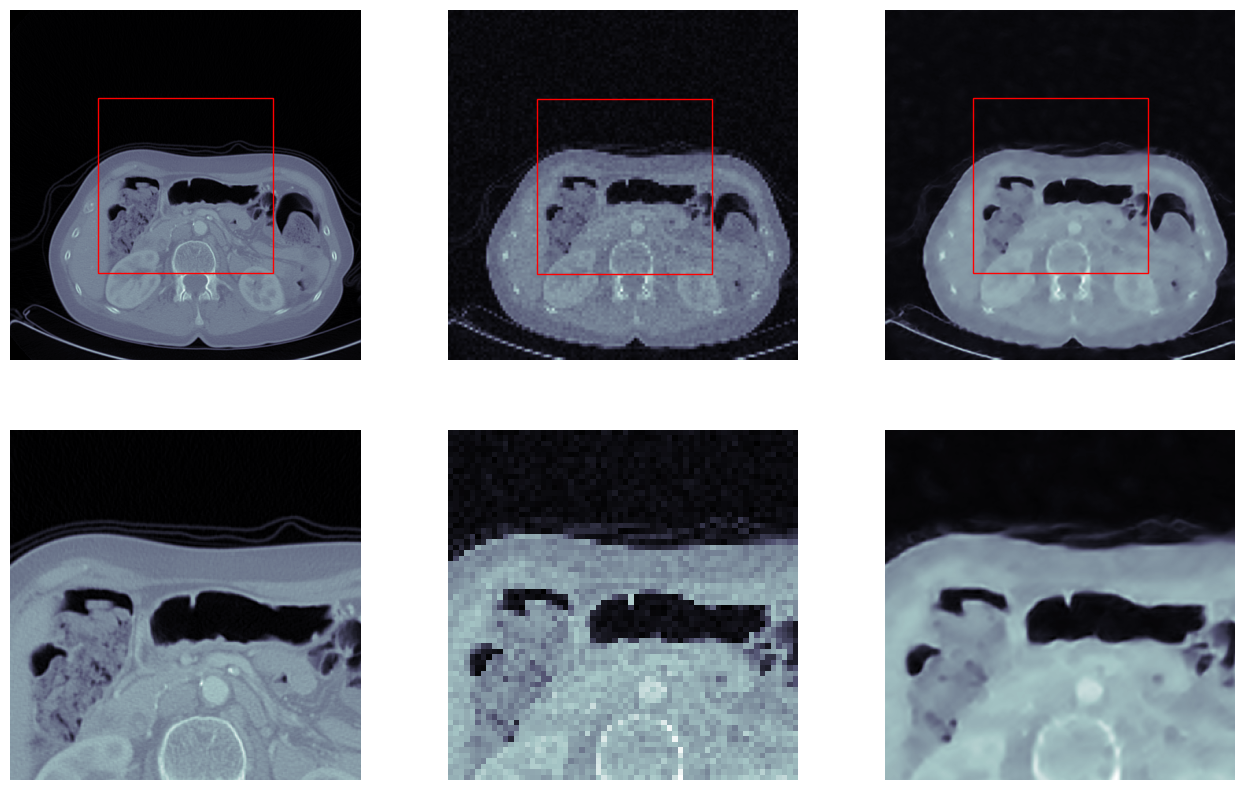

In [ ]:
print(psnr)
print(ssim)
fig, axess = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(16, 10)
axess[0][0].imshow(labels, plt.cm.bone)
axess[0][0].set_axis_off()
axess[0][0].add_patch(Rectangle((128, 128), 256, 256, linewidth=1,edgecolor='r',facecolor='none'))
axess[0][1].imshow(linputs, plt.cm.bone)
axess[0][1].set_axis_off()
axess[0][1].add_patch(Rectangle((32, 32), 64, 64, linewidth=1,edgecolor='r',facecolor='none'))
axess[0][2].imshow(preds, plt.cm.bone)
axess[0][2].set_axis_off()
axess[0][2].add_patch(Rectangle((128, 128), 256, 256, linewidth=1,edgecolor='r',facecolor='none'))
axess[1][0].imshow(labels[128:384, 128:384], plt.cm.bone)
axess[1][0].set_axis_off()
axess[1][1].imshow(linputs[32:96, 32:96], plt.cm.bone)
axess[1][1].set_axis_off()
axess[1][2].imshow(preds[128:384, 128:384], plt.cm.bone)
axess[1][2].set_axis_off()
plt.savefig('example.png', facecolor='white', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

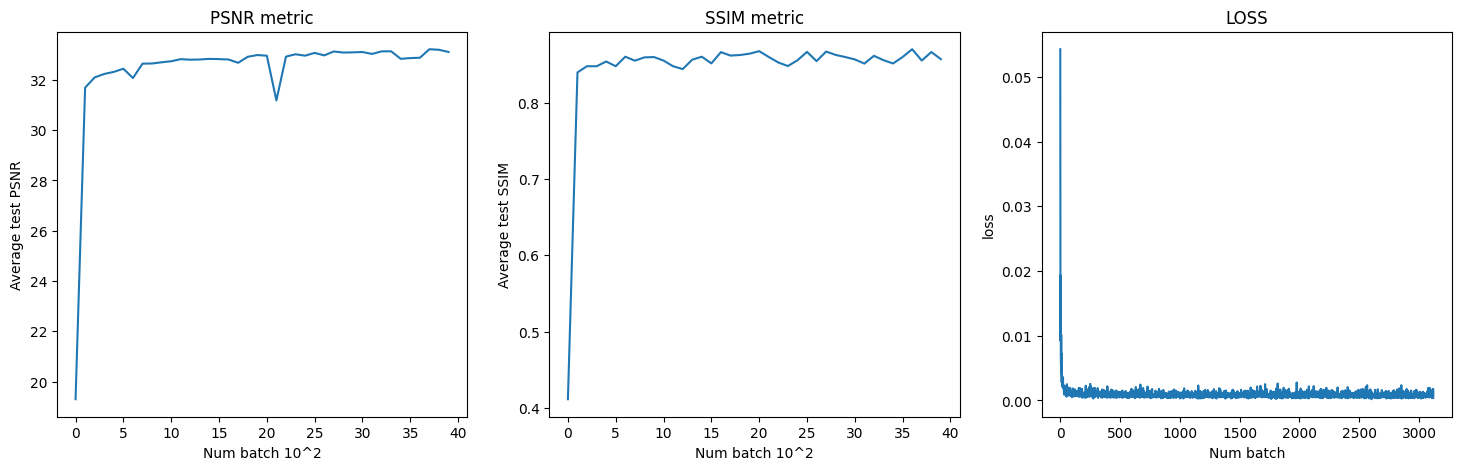

In [ ]:
plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 5)
ax1.plot(eval_psnr_byepoch)
ax1.set_title('PSNR metric')
ax1.set_xlabel('Num batch 10^2')
ax1.set_ylabel('Average test PSNR')
ax2.plot(eval_ssim_byepoch)
ax2.set_title('SSIM metric')
ax2.set_xlabel('Num batch 10^2')
ax2.set_ylabel('Average test SSIM')
ax3.plot(loss_perbatch)
ax3.set_title('LOSS')
ax3.set_xlabel('Num batch')
ax3.set_ylabel('loss')
plt.savefig('plots.png', facecolor='white', bbox_inches='tight')
plt.show()